<a href="https://colab.research.google.com/github/gitudaniel/fastai-course-notes/blob/main/Starting_MNIST_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 25.7MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
pip install fastbook

     |████████████████████████████████| 727kB 28.7MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 1.2MB 45.8MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 


In [3]:
# import fastbook
# fastbook.setup_book()

In [4]:
from fastbook import *

In [5]:
import fastai
print(fastai.__version__)

2.4


In [6]:
from fastai.vision.all import *
#from utils import *

matplotlib.rc('image', cmap='Greys')

- We're going to start simple and gradually scale up.

- Fastai has a simpler version of MNIST with only 3's and 7's

In [7]:
path = untar_data(URLs.MNIST_SAMPLE)

In [8]:
Path.BASE_PATH = path

In [9]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

- `path.ls()` prints a count of items and a list of files relative to where our MNIST_SAMPLE was untarred.

- `path` is a `pathlib` path object. 

- `Pathlib` is part of the standard library but `ls` is not an inbuild method but a method added by the creators of fastai to make it easier.

In [10]:
# show what ls is
path.ls?

In [11]:
# Show what ls does
path.ls??

In [12]:
# show the documentation
doc(path.ls)

In [13]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

- We see that the data in our train folder is labelled as "3" or "7"

In [14]:
# sorted() ensures we get the same order of files
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [15]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [16]:
type(im3)

PIL.PngImagePlugin.PngImageFile

- PIL is the Python Imaging library; the most popular library for working with images on Python by far.

- Our image is a Png file

- To view the numbers that make up this image, we have to convert it into a *Numpy array* or a *PyTorch tensor*.

- A tensor is a PyTorch version of a Numpy array.

- A PyTorch tensor and a Numpy array behave nearly identically much if not most of the time.

- The key difference is that a PyTorch tensor can also be computed on a GPU and not just a CPU.

In [17]:
# Numbers from the top-left of the image as a Numpy array
# get 6 rows and 6 columns
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [18]:
# Numbers from the top-left of the image as a PyTorch tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

- We can slice the array to pick just the part with the top part of the digit in it, and use a Pandas DataFrame to color-code the values using a gradient.

- This shows us clearly how the image is created from the pixel values.

In [19]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


- The background white pixels are stored as the number zero, black is the number 255 and shades of grey are between the two.

- The entire image contains 28 pixels across and 28 pixels down, for a total of 768 pixels.

# Pixel similarity

- As a first try, let's find the average pixel value for every pixel of the threes and do the same for each of the sevens.

- This will give us three group averages which will serve as an "ideal" 3 and 7.

- For classification, we see which of these two "ideal" digits the image is most similar to.

- This will make a good baseline.

- `Baseline` - a super simple model that should be very easy to program from scratch with very little magic and will be better than a random model.

- Always start with a reasonable baseline and build on top of it.

- Step one of our model is to get the average pixel values for each of out two groups.

In [20]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

- We check that one of the images looks okay.

- Remember that our images are now tensors. Jupyter displays tensors as values since it only displays images by default for PIL objects.

- To display the tensor as an image we use fastai's `show_image` function

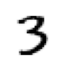

In [21]:
show_image(three_tensors[1])

In [22]:
type(three_tensors)

list

In [23]:
three_tensors[1].shape

torch.Size([28, 28])

- We need to get the average of all of those threes.

- Currently `three_tensors` is a list of 28 x 28 images.

- We want to stack all those images into a single three-dimensional tensor to make it easier to perform mathematical computations on it.

- PyTorch comes with a function called `stack`.

- Some operations in PyTorch, such as taking a mean require us to cast our integer types to float types.

- The pixels in an image range from 0 - 255

- In computer vision, when working with floats, they are expected to be between zero and one, so we'll divide by 255

In [24]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

- `Rank` - number of axes (dimensions) in a tensor.

- `Shape` - size of each axis of a tensor.

- `stacked_threes` is now a rank 3 tensor because it has 3 axes.

- We get the rank of a tensor by getting the length of its shape or getting the number of dimensions.

- We now have 6131 images each of size 28 x 28 pixels.

- The semantics of a tensor are entirely up to us and how we construct it. The first axis doesn't have to be the number of images

In [25]:
# length of its shape
len(stacked_threes.shape)

3

In [26]:
# number of dimensions
stacked_threes.ndim

3

- We can now compute what the ideal three and seven look like.

- For every pixel position, we calculate the mean over all images by taking the mean along dimension zero of our stacked, rank-3 tensor.

- Dimension zero is the dimension which indexes over all the images.

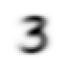

In [27]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

In [28]:
mean3.shape

torch.Size([28, 28])

`stacked_threes.mean()` returns the average pixel across the rank-3 tensor

In [29]:
stacked_threes.mean()

tensor(0.1415)

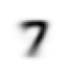

In [30]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

- We can now pick an arbitrary "3" and measure its distance from each of these ideal digits.

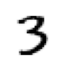

In [31]:
a_3 = stacked_threes[1]
show_image(a_3)

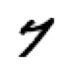

In [32]:
a_7 = stacked_sevens[1]
show_image(a_7)

- We can't just add up the differences between the pixels of this digit and the ideal digit.

- This is because some differences will be positive and others will be negative and these differences cancel out and shows that the image has zero total differences from the ideal.

- This is very misleading.

- There's two ways data scientists measure distance in this context:
  - `L1 norm/Mean Absolute Difference` - Take the mean of the absolute value of differences (replace negatives with positives and get the mean)
  - `L2 norm/Root Mean Squared Error (RMSE)` - Take the mean of the square of differences and then take the square root.

- Intuitively the difference between `L1 norm` and `mean squared error (MSE)` is that the latter will penalize bigger mistakes more heavily than the former and be more lenient with small mistakes.

In [33]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [34]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

- The distance of our digit to the mean of three is closer than its distance to the mean of seven. This is true for both the `mean absolute error` and the `root mean squared error`.

- This means that we can predict that our digit is a three.

- In this case our simple model gives a correct prediction.

- PyTorch already provides both the `MAE` & `RMSE` as loss functions inside the `torch.nn.functional` (imported as `F`).

- In it *MSE* refers to `mean squared error` and *L1* refers to the `mean absolute error` (`L1 norm` in math)

In [35]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3.float(), mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

# Computing metrics using broadcasting

- A metric tells us how good our model is by comparing the prediction to the correct label.

- We use *accuracy* as a metric in classification models since it is understandable to most people

In [36]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

- We want to write a function `is_3` that will decide if an image is a 3 or a 7 depending on which it is closer to.

- For this, we'll need to define a notion of distance, i.e. a function that calculates the distance between two images.

- We'll do this using the mean absolute error

In [37]:
# mean((-1, -2)) -> take the mean along the last and the second last axis i.e the x and y axis
def mnist_distance(a, b): return (a - b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

- In order to calculate overall accuracy, we'll need to calculate the distance to the ideal three for every image in the validation set.

- Our distance function is designed for comparing two single images but can work for our stacked tensor through `broadcasting`.

- `Broadcasting` -> a PyTorch feature that automatically expands the tensor of the smaller rank to have the same size as the one with the larger rank.

- In our case it treats `mean3` as 1010 copies of the same image and subtracts each of those copies from each "three" in `valid_3_tens

In [38]:
valid_3_distance = mnist_distance(valid_3_tens, mean3)
valid_3_distance, valid_3_distance.shape

(tensor([0.1397, 0.1058, 0.1463,  ..., 0.1390, 0.1183, 0.1605]),
 torch.Size([1010]))

In [39]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [40]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

- Thanks to `broadcasting`, we can test it on the full validation set of threes.

- This enables us to get rid of loops since loops make things slower moreso on the GPU.

In [41]:
is_3(valid_3_tens)

tensor([ True,  True, False,  ...,  True,  True, False])

In [42]:
accuracy_3s = is_3(valid_3_tens).float().mean()

accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

- As we can see, we have a model with a 95% accuracy in predicting 3s and 7s using broadcasting.

- Our model however, cannot be defined as a machine learning model according to Arthur Samuel i.e *Automatic means of testing the actual effectiveness of any parameter assignment in terms of actual performance and provide a mechanism for altering the weight assignment so as to maximise the performance.*

- To do better, let's try a system that does some real learning, i.e. can automatically modify itself to improve its performance.

# Stochastic Gradient Descent (SGD)

- Instead of trying to find the similarity of an image with an "ideal" image, we could instead look at each individual pixel, and come up with a set of weights for each pixel, such that the highest weights are associated with those pixels most likely to be black for a particular category.

- For instance, pixels towards the bottom right are not very likely to be activated for a seven so they should have low weight for a seven, but are more likely to be activated for an eight so they should have high weight for an eight.

- We can represent this as a function:
    ```python
      def pr_eight(x,w) = (x*w).sum()
    ```

- Here we are assuming that `X` is an image represented as a vector and the weights are a vector `W`.

- If the image we're looking at has pixels with a high weight it's going to end up with a high probability.

- If we have this function, then we just need some way to update the weights to make them a little bit better.

- With such an approach, we can repeat this step a number of times, making the weights better and better until they are as good as we can make them.

- Searching for the best vector `W` is a way to search for the best function for recognising a digit.

- To be more specific, below are the steps required to turn this function into a machine learning classifier:
  - *Initialize* the weights. We initialize the weights to random values since we have a routine to improve these weights.
  - For each image, use the weights to predict whether it appears to be a three or a seven.
  - Based on these predictions, calculate how good the model is (its `loss`).
  - Calculate the `gradient`, which measures for each weight, how changing that weight would change the loss.
  - `Step` (change) all the weights based on the `gradient` calculation.
  - Go back to step one and repeat the process.
  - Stop training when you decide that the model is good enough, or you don't want to wait any longer.

- These 7 steps are the key to the training of all deep learning models.

- This technique is called `Gradient Descent`

- Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case.

- We'll define a simple function (the quadratic) and assume it's our loss function and x is our weighted parameter.

In [43]:
def f(x): return x**2

/usr/local/lib/python3.7/dist-packages/fastbook/__init__.py:73: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:25.)
  x = torch.linspace(min,max)


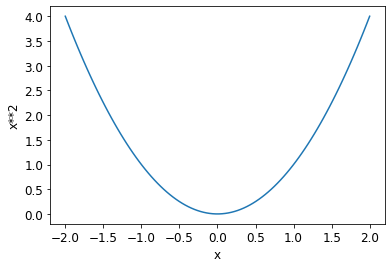

In [44]:
plot_function(f, 'x', 'x**2')

- The sequence of steps we described above starts by picking some random value for a parameter, and calculating the value of the loss

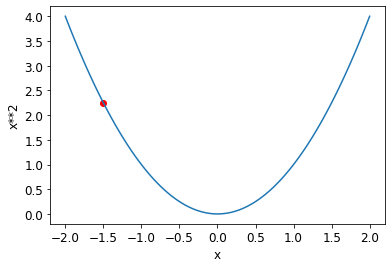

In [45]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

- We now look to see what would happen if we increased or decreased our parameter by a little bit - the `adjustment`.

- This is simply the slope at a particular point.

- We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times.

- Eventually, we'll get to the lowest point on the curve.

- The basic idea goes back to Isaac Newton, who pointed out that we can optimize arbitrary functions this way.

- Regardless of how complicated our functions become, this basic approach of gradient descent will not significantly change.

- The only minor changes are some handy ways we can make it faster, by finding better steps.

## The gradient

- The one magic step is the bit where we calculate the *gradient*.

- We use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down.

- In other words, the gradients will tell us how much we have to change each weight to make our model better.

- From highschool math, gradient is defined as "rise/run" i.e. the change in the value of the function divided by the change in the value of the parameter.

- The *derivative* of a function tells you how much a change in the parameters of a function will change its result.

- It is a function that calculates the change rather than the value.

- The derivative of the quadratic function at the value three tells us how rapidly the function changes at the value three.

- When we know how our function will change, then we know what to do to make it smaller.

- This is the key to machine learning: having a way to change the parameters of a function to make it smaller.

- Our function has lots of weights that we need to adjust, so when we calculate the derivative, we won't get back one number but lots of them - a gradient for every weight.

- You can calculate the derivative with respect to one weight and treat all the others as constant, then repeat that for each weight.

- This is how gradients are calculated for every weight.

- Luckily PyTorch is able to automatically compute the derivative of any function so you don't have to calculate any gradients yourself.

In [46]:
# Pick a tensor value which we want gradients at
xt = tensor(3.).requires_grad_()

- `requires_grad_()` tells PyTorch that we want to calculate gradients with respect to that variable at that value.

- An underscore at the end of a method in PyTorch means that it is an `in-place operation`.

- An `in-place operation` directly changes the content of a given linear algebra, vector or tensor without making a copy.

- In our function above `requires_grad_` modifies `tensor(3.)` to tell PyTorch that we want to calculate gradients on it.

- We now calculate our function with that value.

In [47]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

- Finally, we tell PyTorch to calculate the gradient for us

In [48]:
yt.backward()

- `backward()` refers to `back propagation` which is the name given to the process of calculating the derivative of each layer.

- We can now view the gradients by checking the `grad` attribute of our tensor

In [49]:
xt.grad

tensor(6.)

In [50]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [51]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

- Our gradients are 2*x as expected

In [52]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

- The gradient only tells us the slope of our function, it doesn't actually tell us exactly how far to adjust the parameters.

- It gives us some idea of how far, if the slope is very large it suggests that we have more adjustments to do.

- Whereas if the slope is very small it may suggest that we are close to the optimal value.

## Stepping with a learning rate

- Deciding how to change our parameters based on the value of the gradients is an important part of the deep learning process.

- Nearly all approaches start with the basic idea of multiplying the gradient by some small number called the `learning rate (LR)`.

- People often select a learning rate just by trying a few numbers and finding which one results in the best model after training. The learning rate is often a number between 0.001 and 0.1, although it could be any number.

- Once you've picked your learning rate, you can adjust your parameters using this function:
  ```
  w -= gradient(w) * lr
  ```

- This is known as `stepping` your parameters using an `optimizer step`.

- If you pick a learning rate that's too low it can mean having to do a lot of steps.

- Picking a learning rate that's too high is even worse, it can result in the loss getting worse or it may bounce around rather than actually diverging.

## An end-to-end SGD example

- Let's look at an SGD example and see how finding a minimum can be used to train a model to fit data better.

- Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill, and then would be slowest at the top, and it would speed up as it went down the hill. You want to build a model of how the speed changes over time. If you're measuring the speed manually every second for 20 seconds, it might look something like this

In [53]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

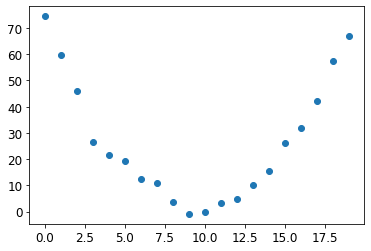

In [54]:
# torch.randn(20)*3 adds a random number to every observation since measuring things manually isn't precise
# The speed is calculated as the result of a quadratic function
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time, speed)

- ```torch.randn(20)*3``` adds a bit of random noise since measuring things manually isn't precise.

- Using SGD we can try to find a function that matches our observations.

- We can't consider every possible function, so let's use a guess that it'll be quadratic, i.e. a function of the form `a*(time**2) + (b*time) + c`.

- We want to distinguish clearly between the functions input (the time we're measuring the coaster's speed) and its parameters (the values that define which quadratic we're trying).

- Let's collect the parameters in one argument and thus separate the input `t` and the parameter `params` in the function's signature.

In [55]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

- We've restricted the problem of finding the best imaginable function that fits the data to finding the best quadratic function.

- This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters `a`, `b`, and `c`.

- To find the best quadratic function, we need to find the best values for `a`, `b`, and `c`.

- If we can solve the problem for the three parameters of the quadratic function, we'll be able to apply the same approach for other more complex functions with more parameters such as a neural net.

- We need to define what we mean by "best". We define this precisely by choosing a *loss function*, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions.

- For continuous data, it's common to use *mean squared error*

In [56]:
def mse(preds, targets): return ((preds - targets)**2).mean()

- Let's work through our 7 step process:

**Step 1**:
- Initialize parameters to random values and tell PyTorch that we want to track their gradient using `requires_grad_`

In [57]:
params = torch.randn(3).requires_grad_()

In [58]:
orig_params = params.clone()

**Step 2:**
- Calculate the predictions

In [59]:
preds = f(time, params)
preds

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

- Let's create a little function to see how close our predictions are to our targets and take a look.

In [60]:
def show_preds(preds, ax=None):
  if ax is None: ax = plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

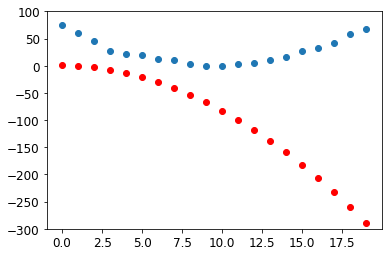

In [61]:
show_preds(preds)

- This doesn't look very close -- our random parameters suggest that the roller coaster will end up going backwards since we have negative speeds

**Step 3:**
- Calculate the loss

In [62]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

- Our goal is to improve this. To do that we'll need the gradients

**Step 4:**
- Calculate the gradients (an approximation of how the parameters need to change).

In [63]:
loss.backward()
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

- We pick a learning rate of $10^{-5}$

In [64]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

- We can use these gradients to improve our parameters

In [65]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

**Step 5:**
- Step the weights (update the parameters based on the gradients we just calculated)

- We use the `.data` attribute in PyTorch to make sure that the gradient isn't calculated of the actual step we're doing.

- The gradient should only be calculate of the function `f`.

In [66]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None  # remove the gradients previously calculated.

- Let's see if the loss improved

In [67]:
preds = f(time, params)
mse(preds, speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

- We notice that the loss has indeed reduced from the initial calculation.

- We also plot the function

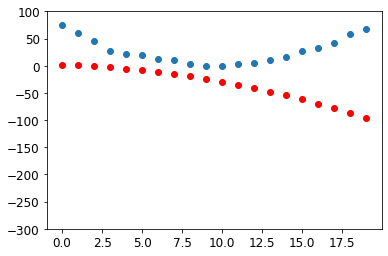

In [68]:
show_preds(preds)

- The plot has also improved.

- We need to repeat this a few times, so we'll create a function to apply one step.

In [69]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

**Step 6:**
- We repeat the process.

- By looping and performing many improvements, we hope to reach a good result.

In [70]:
for i in range(10): apply_step(params)

5435.53564453125
1577.44921875
847.3778076171875
709.2225341796875
683.0758056640625
678.1243896484375
677.1838989257812
677.0023803710938
676.9645385742188
676.9537353515625


In [71]:
params = orig_params.detach().requires_grad_()

- The loss is going down just as we'd hoped.

- Looking only at the loss disguises the fact that each iteration represents an entirely different quadratic function being tried on the way to find the best possible quadratic function.

- We can see this process visually if, instead of printing out the loss, we plot the function at every step.

- Then we can see how the shape is approaching the best possible quadratic function for our data.

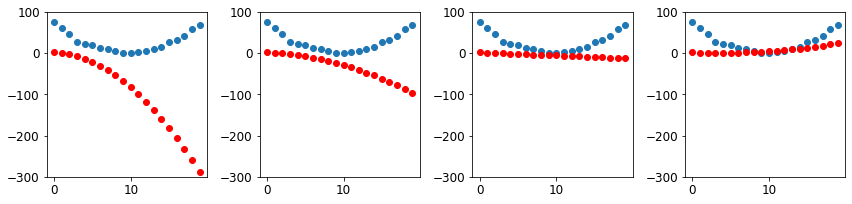

In [72]:
_, axs = plt.subplots(1, 4, figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

**Step 7:**

- Stop.

- We decided to stop arbitrarily after 10 epochs.

- In practice, we watch the training and validation losses and our metrics decide when to stop.

# MNIST loss function

- We need gradients in order to improve our model using SGD, and in order to calculate gradients, we need some loss function that represents how good our model is.

- Gradients are a measure of how that loss function changes with small tweaks to the weights.

- In choosing a loss function, the obvious approach would be to use accuracy, which is our metric, as our loss function as well.

- In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to the overall accuracy.

- The gradient of a function is how much the value of a function goes up or down divided by how much you changed the inputs.

- Accuracy only changes when a prediction changes from a 3 to a 7 or vice versa meaning that a small change in weights isn't likely to cause any prediction change.

- Therefore the problem with accuracy is that the gradient will be zero almost everywhere because a very small change in the value of a weight will often not change the accuracy at all.

- This makes accuracy a poor choice as a loss function because with the gradients as zero the model is unable to learn from that number.

- We need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss.

- We already have our `x`'s i.e. the images themselves.

- We'll concatenate them into a single tensor using `torch.cat()`, and also change them from a list of matrices (rank 3 tensor) to a list of vectors (rank 2 tensor) using the `view` method.

- `view` is a PyTorch method that changes the shape of a tensor without changing its contents.

- `-1` is a special parameter to `view` that means make this axis as big as necessary to fit all the data

In [73]:
# view(-1, 28*28) -> put everything in as many rows of length 28*28 as is necessary
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

- We need a label for each. We'll use 1 for threes and 0 for sevens

In [74]:
# unsqueeze(1) create a matrix with one column
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)
train_x.shape, train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

- A dataset in PyTorch is required to return a tuple of (x, y) when indexed.

- Python provides a `zip` function which when combined with a list, provides a simple way to get this functionality.

In [75]:
dset = list(zip(train_x, train_y))
x,y = dset[0]  # destructuring the tuple
x.shape, y

(torch.Size([784]), tensor([1]))

In [76]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

- We initialize a random weight for every pixel

In [77]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [78]:
torch.randn(3)

tensor([ 0.6863, -0.3278,  0.7950])

In [79]:
torch.randn((3,1))

tensor([[0.2815],
        [0.0562],
        [0.5227]])

In [80]:
weights = init_params((28*28, 1))  # the 1 tells Pytorch that we want the results as a column

- The function `weights*pixels` won't be flexible enough.

- It's always equal to zero when the pixels are equal to zero i.e. its intercept is zero.

- The formula for a line is `y=w*x_b`; we still need the b

In [81]:
bias = init_params(1)

In [82]:
bias

tensor([-0.2384], requires_grad=True)

- In neural networks, the `w` in the equation `y=w*x+b` is called the *weights* and `b` is called the *bias*.

- Together, the weights and bias make up the parameters.

- We can now calculate the prediction for one image.

In [83]:
(train_x[0]*weights.T).sum() + bias

tensor([21.2574], grad_fn=<AddBackward0>)

- We don't use a python for loop to calculate the prediction of each image.

- This is because for loops are very slow and don't run on the GPU.

- We need to represent as much of the computation in a model as possible using higher-level functions

- We can use *matrix multiplication* to calculate `w*x` for every row of a matrix.

- In Python, matrix multiplication is represented with the `@` operator

In [84]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[21.2574],
        [10.8843],
        [18.9925],
        ...,
        [ 6.1623],
        [ 7.2080],
        [-0.1182]], grad_fn=<AddBackward0>)

- The `batch@weights + bias` equation is one of the two fundamental equations of any neural network (the other one is the *activation function*).

- To decide if an output represents a 3 or a 7, we can just check if its greater than zero.

- Our accuracy for each item can be calculated with:

In [85]:
corrects = (preds>0.0).float() == train_y  # broadcasting
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [ True]])

In [86]:
# .item() unwraps a tensor to create a normal python scalar
corrects.float().mean().item()

0.5004033446311951

- Our randomly initialized model is right about half the time at predicting 3's from 7's

- Let's see what the change in accuracy is for a small change in one of the weights.

In [87]:
weights[0].data *= 1.0001

In [88]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5004033446311951

- We get back the exact same figure.

- We can see that we need gradients in order to improve our model using SGD, and in order to calculate gradients we need some *loss function* that represents how good our model is.

- Gradients are a measure of how that loss function changes with small tweaks to the weights.

- Accuracy as a loss function will not be useful in this case, due to the gradient being zero most of the time.

- We need a loss function which, when our weights result in slightly better predictions, gives us a better loss.

- The loss function receives not the images themselves, but the prediction from the model.

- One of the arguments to the loss function will be `predictions`, a vector (rank-1 tensor), indexed over the images, of values between 0 and 1, where each value is the prediction indicating how likely the component's image is a 3.

- The purpose of the loss function is to measure the difference between predicted values and true values (labels/targets).

- The loss will be smaller i.e. better when the predictions are closer to the targets.

- Another argument to the loss function will be the `targets`, a vector indexed over the images, with a value of 0 or 1 that tells us whether the image is actually a 3.

- For example, let's say we had three images of a 3, a 7 and a 3. Suppose our model predicted with high confidence the first was a 3, slight confidence the second was a 7 and fair confidence (incorrectly) that the last was a 7. This would mean our loss function would receive these values as inputs:

In [89]:
trgts = tensor([1,0,1])
prds = tensor([0.9, 0.4, 0.2])

- Here's a first try at a loss function that measures the distance between predictions and targets:

In [90]:
def mnist_loss(predictions, targets):
  """Return 1-predictions where targets==1 and predictions where targets==0"""
  return torch.where(targets==1, 1-predictions, predictions).mean()

- `torch.where(a, b, c)` is the equivalent of running the list comprehension `[b[i] if a[i] else c[i] for i in range(len(a))], except it works on tensors, at C/CUDA speeds.

- Our function measures how distant each prediction is from 1 if it should be 1, and how distant it is from 0 if it should be 0, and then takes the mean of all those distances.

In [91]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [92]:
mnist_loss(prds, trgts)

tensor(0.4333)

- If we change the prediction for the one "false" target from 0.2 to 0.8, the loss will go down indicating that this is a better prediction

In [93]:
mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

tensor(0.2333)

- `mnist_loss` as it is currently defined assumes that predictions are always between zero and one.

- We need to ensure that this is always the case.

- The `sigmoid function` always outputs a number between zero and one

## Sigmoid

- The `sigmoid` function is defined by:

In [94]:
# torch.exp is the same as e
def sigmoid(x): return 1/(1+torch.exp(-x))

In [95]:
math.e

2.718281828459045

In [96]:
math.e**2 == torch.exp(tensor(2.))

tensor(True)

- PyTorch already defines this for us.

- The sigmoid function is important in deep learning since we always want to ensure values are between zero and one.

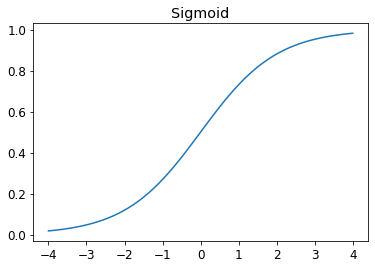

In [97]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

- The sigmoid function takes in any input value, positive or negative and outputs a value between zero and one.

- Smaller numbers give an output closer to zero and larger numbers give an output closer to one.

- It never goes below zero and beyond one.

- It's also a smooth curve that only goes up, making it easier for SGD to find meaningful gradients.

- We update `mnist_loss` to apply `sigmoid` to the inputs

In [98]:
def mnist_loss(predictions, targets):
  predictions = predictions.sigmoid()
  return torch.where(targets==1, 1-predictions, predictions).mean()

- We can now be confident that our loss function will work, even when the predictions are not between 0 and 1.

- Metrics, are the numbers we really care about i.e. accuracy.

- These are things printed out at the end of every epoch that tell us how our model is really doing.

- When judging the performance of a model it is important to focus on the metrics.

- The loss function needs to respond to small changes in confidence level.

- This means that sometimes the loss doesn't really reflect what we are trying to achieve, but is rather a compromise between our real goal, and a function that can be optimized using its gradient.

- The loss function is calculated for each item in our dataset, and at the end of an epoch these are all averaged, and the overall mean is reported for the epoch.

- In summary, the key difference between the loss and the metric is that the metric is to drive human understanding and the loss is to drive automated learning.

### SGD and mini-batches

- Now that we have a loss function that is suitable to drive SGD, we can now consider the `optimization step`.

- The optimization step is where we step (change or update) the weights based on the gradient.

- To do this we need to calculate the loss of one or more data items.

- We calculate the loss of a few data items at a time, called a `mini-batch`.

- The number of items in a mini-batch is called a `batch size`.

- We take mini-batches because:
  - Calculating the loss for the whole dataset takes a very long time.
  - Calculating the loss for each individual item does not use much information and results in a very imprecise and unstable gradient.

- A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradient on the loss function, but it takes longer and you will get less mini-batches per epoch.

- Mini-batches are ideal since we train on a GPU and GPUs only perform well if they have lots of work to do at a time.

- From data augmentation, we get better generalization if we vary things during training.

- A simple and effective thing we can do is to randomly shuffle our dataset on every epoch before we create mini-batches.

- PyTorch and fastai provide a `DataLoader` that does the shuffling and mini batch collation for you.

In [99]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

- `Dataset` - A PyTorch collection that contains tuples of independent and dependent variables

- For training a model, we just don't want any collection but a PyTorch collection i.e. a *dataset*

In [100]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

- When we pass a Dataset to a Dataloader, we get back many batches that are themselves tuples of tensors representing batches of independent and dependent variables.

In [101]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

### Putting it all together

- We can now write our first training loop for a model using SGD.

- In code, our process will be implemented something like this for every epoch:
```python
    for x,y in dl:
        pred = model(x)
        loss = loss_func(pred, y)
        loss.backward()
        parameter -= parameter.grad - lr
```

- First, let's re-initialize our parameters:

In [102]:
weights = init_params((28*28,1))
bias = init_params(1)

- A `DataLoader` can be created from a `Dataset`

In [103]:
dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

- We'll do the same for the validation set.

In [104]:
valid_dl = DataLoader(valid_dset, batch_size=256)

- Let's create a mini-batch of size 4 for testing

In [105]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [106]:
preds = linear1(batch)
preds

tensor([[ 0.9350],
        [ 7.4629],
        [-0.6780],
        [ 6.4046]], grad_fn=<AddBackward0>)

In [107]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.2369, grad_fn=<MeanBackward0>)

- Now we calculate the gradients:

In [108]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0153), tensor([-0.1070]))

- Let's put all that in a function

In [109]:
def calc_grad(xb, yb, model):
  preds = model(xb)
  loss = mnist_loss(preds, yb)
  loss.backward()


In [110]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0307), tensor([-0.2140]))

In [111]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0460), tensor([-0.3210]))

- When we call the function a second time, notice that the gradients have changed. This is very concerning.

- `loss.backward` not only calculates the gradient, it also adds the gradients of `loss` to any gradients that have been stored.

- To prevent this from happening we have to set the current gradients to zero first.

In [112]:
weights.grad[541]

tensor([-0.1044])

In [113]:
# change the weights.grad tensor to be a tensor containing zeros
# the _ just means do it in place
weights.grad.zero_()
bias.grad.zero_();

- The remaining step will be to update the weights and bias based on the gradient and learning rate.

- We have to be careful and tell PyTorch not to take the gradient of this step too, otherwise it gets very confusing when we try to compute the derivative at the next batch.

- We do this by assigning to the `data` attribute of a tensor

In [114]:
def train_epoch(model, lr, params):
  """A basic standard SGD loop."""
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    for p in params:
      p.data -= p.grad*lr
      p.grad.zero_()

> The difference between `gradient descent` and `stochastic gradient descent` is that gradient descent calculates the gradient on the entire dataset while stochastic gradient descent loops through a mini-batch and calculates the gradient on that

- We also want to know how we're doing by looking at the accuracy of the validation set.

- To decide if an input represents a 3 or a 7, we can just check whether it's greater than zero.

- The accuracy of each item can be calculated (using broadcasting) with:

In [115]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [ True]])

- The above gives us this function to calculate our validation accuracy:

In [116]:
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds>0.5) == yb
  return correct.float().mean()

- You'll notice that we're working with the sigmoid of the predictions.

- To measure the accuracy we use `(preds>0.5)`, this is because on the sigmoid curve 0 corresponds to 0.5

In [117]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

In [118]:
def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
  return round(torch.stack(accs).mean().item(), 4)

In [119]:
validate_epoch(linear1)

0.4642

- Let's train for one epoch and see if the accuracy improves.

In [120]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6096

In [121]:
for i in range(20):
  train_epoch(linear1, lr, params)
  print(validate_epoch(linear1), end=' ')

0.8158 0.8973 0.931 0.9437 0.9505 0.953 0.9564 0.9608 0.9613 0.9622 0.9627 0.9647 0.9661 0.9676 0.9696 0.9691 0.9691 0.9691 0.9696 0.9711 

- We're already at about the same accuracy as our "pixel similarity" approach, and we've created a general purpose foundation we can build on.

- The next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an *optimizer*.

## Creating an optimizer

- PyTorch provides some useful classes to make implementation easier.

- A "module" is an object of a class that inherits from the PyTorch `nn.module` class.

- Objects of this class behave like a standard Python function, in that you can call it using parentheses, and it will return activations of a model.

- First, we'll replace our `linear1()` function with PyTorch's `nn.Linear` module.

- `nn.Linear` does the same thing as our `init_params` and `linear1` together.

- It contains both the weights and bias in a single class

In [122]:
linear_model = nn.Linear(28*28, 1)

- Every PyTorch module knows what parameters it has that can be trained; they are available through the `parameters` method.

In [123]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

- We can use this information to create an optimizer

In [124]:
class BasicOptim:
  def __init__(self, params, lr): self.params, self.lr = list(params), lr

  def step(self, *args, **kwargs):
    for p in self.params: p.data -= p.grad.data * self.lr

  def zero_grad(self, *args, **kwargs):
    for p in self.params: p.grad = None

- We can create our optimizer by passing in the model's parameters:

In [125]:
opt = BasicOptim(linear_model.parameters(),lr)

- Our training loop can now be simplified to:

In [126]:
def train_epoch(model):
  for xb, yb in dl:
    calc_grad(xb, yb, model)
    opt.step()
    opt.zero_grad()

- Our validation function doesn't need to change

In [127]:
validate_epoch(linear_model)

0.4185

- Putting our training loop into a function:

In [129]:
def train_model(model, epochs):
  for i in range(epochs):
    train_epoch(model)
    print(validate_epoch(model), end=' ')

In [130]:
train_model(linear_model, 20)

0.4932 0.7798 0.8516 0.9165 0.9336 0.9487 0.956 0.9633 0.9658 0.9672 0.9692 0.9721 0.9736 0.9741 0.976 0.976 0.9775 0.9775 0.978 0.9785 

- fastai provides the `SGD` class which, by default, does the same thing as our `BasicOptim`

In [131]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.7983 0.8535 0.917 0.9355 0.9492 0.958 0.9643 0.9663 0.9672 0.9707 0.9726 0.9736 0.9751 0.9755 0.9765 0.9775 0.9775 0.978 0.9785 

- fastai also provides a `Learner.fit` that can be used instead of `train_model`.

- To create a `Learner` we first need to create `DataLoaders` by passing in our training and validation `DataLoader`.

- `DataLoaders` stores away a `DataLoader` as a `.train` and a `.valid`.

- With `DataLoaders` we now have a sigle object that knows all the data we have.

- It can make sure that the training `DataLoader` is shuffled and the validation `DataLoader` isn't shuffled so that everything works properly.

In [132]:
dls = DataLoaders(dl, valid_dl)

- To create a `Learner` class without using an application (such as `cnn_learner`), we need to pass in: the `DataLoaders`, the model, the optimization function, the loss function, and optionally any metrics to print

In [133]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

- We can now call `fit`

In [134]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636508,0.503531,0.495584,00:00
1,0.533227,0.187808,0.842002,00:00
2,0.195589,0.183700,0.833170,00:00
3,0.085569,0.107622,0.911187,00:00
4,0.045021,0.078366,0.933759,00:00
5,0.029193,0.062697,0.946516,00:00
6,0.022696,0.052944,0.955348,00:00
7,0.019819,0.046463,0.961727,00:00
8,0.018365,0.041913,0.965653,00:00
9,0.017493,0.038563,0.966634,00:00


- With these classes, we can now replace a linear function with a neural network

## Adding a non-linearity

- A linear classifier is very constrained in terms of what it can do.

- To make it a bit more complex (and able to handle more tasks), we need to add a non-linearity between two linear classifiers, and this is what gives us a neural network.

- Below is the entire definition of a basic neural network:

In [135]:
def simple_net(xb):
  """res.max(tensor(0.0)) takes any negative numbers and turns them into zeros.
  The first and third lines are known as linear layers.
  The second line is known as a nonlinearity or activation function.
  """
  res = xb@w1 + b1
  res = res.max(tensor(0.0))  # recified linear unit (ReLU)
  res = res@w2 + b2
  return res

- Here, `w1` and `w2` are weight tensors and `b1` and `b2` are bias tensors; i.e. parameters that are initially randomly initialized.

- Our `simple_net` function is an example of *function composition*.

- `Function composition` - take the result of a function and pass it to a new one.

- Every neural network is basically doing function composition of linear layers and activation functions.

In [136]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

- `w1` has 30 output activations (meaning that `w2` must have 30 input activations so that they match).

- This means that the first layer can construct 30 different features, each representing some different mix of pixels.

- You can change the `30` to anything you like, to make the model more or less complex.

- The function `res.max(tensor(0.0))` is called a *rectified linear unit (ReLU)*.

- It replaces every negative number with zero.

- It is also available in PyTorch as `F.relu`:

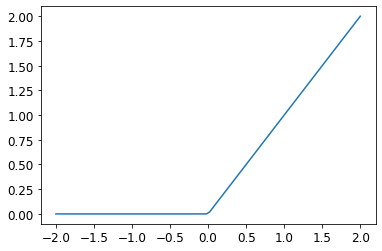

In [137]:
plot_function(F.relu)

- According to the `Universal Approximation Theorem` if the size of the weights and bias matrices are big enough and you can find the right parameters, then our `simple_net` function can solve any computable problem to an arbitrarily high level of accuracy (including the function of how to recognize 3s and 7s.

- This is only possible because of the `max` function that adds a non-linearity to our `simple_net` function.

- Mathematically, the composition of two linear functions is a linear function. Without non-linear functions, we can stack as many linear classifiers on top of each other and it will just be the same as one linear classifier.

>> A series of any number of linear layers in a row can be replaced with a single linear layer with a different set of parameters.

- We can replace our `simple_net` code with something a bit simpler by taking advantage of PyTorch:

In [138]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

- `nn.Sequential` creates a module which will call each of the listed layers or functions in turn. It is an easier way to do function composition.

- `F.relu` is a function, not a PyTorch module.

- `nn.ReLU` is a PyTorch module that does exactly the same thing.

- When using `nn.Sequential` PyTorch requires us to use the module version and since modules are classes, we have to instantiate them i.e. `nn.ReLU()`.

In [139]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [140]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.319728,0.406920,0.505397,00:00
1,0.148601,0.235673,0.798332,00:00
2,0.082089,0.117067,0.915604,00:00
3,0.053686,0.078488,0.938665,00:00
4,0.040527,0.061038,0.955348,00:00
5,0.033825,0.051260,0.964181,00:00
6,0.029992,0.045093,0.966143,00:00
7,0.027511,0.040880,0.968106,00:00
8,0.025728,0.037834,0.969578,00:00
9,0.024352,0.035526,0.972522,00:00


> For deeper models, you may want to use a lower learning rate and a few more epochs.

- The training process is recorded in `learn.recorder`, with the table of output stored in the `values` attribute.

- We can plot the accuracy over training as:

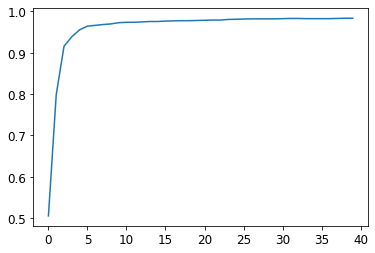

In [141]:
# itemgot(2) get the third item (index 2) from every row (batch_accuracy) for plotting
plt.plot(L(learn.recorder.values).itemgot(2))

- ...and view the final accuracy:

In [142]:
learn.recorder.values[-1][2]

0.983316957950592

- At this point we have:
  - A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters.
  - A way to find the best set of parameters for any function (stochastic gradient descent).

- Below we see a way to look into what the model is doing.

- To understand the features that make up the first layer, we can plot them as seen below. For layers other than the first though we have to be a lot more sophisticated.

In [143]:
m = learn.model
m

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [144]:
m[0].parameters()

<generator object Module.parameters at 0x7f5fa8ed62d0>

In [145]:
w,b = m[0].parameters()
w.shape, b.shape

(torch.Size([30, 784]), torch.Size([30]))

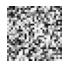

In [146]:
show_image(w[0].view(28,28))

- In practice, we can add as many linear layers as we want as long as we add a nonlinearity between each pair of linear layers (making the model deeper).

- However, the deeper the model gets, the harder it is to optimise the parameters in practice.

- **Why use deeper models?**
> Performance. With a deeper model, we do not need to use as many parameters; we can use smaller matrices, with more layers, and get better results than we would with larger matrices and fewer layers. We can therefore train quicker and our model takes up less memory.

- Below we see what happens when we train an 18 layer model using the same approach:

In [147]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,time
0,0.154869,0.051741,0.994112,02:55


- It gives nearly 100% accuracy, a big difference compared to our `simple_net` function.

### Summary of key concepts related to SGD.

> Activations - numbers that are calculated.

> Parameters - numbers that are randomly initialized, and optimised (the numbers we're learning).

> ReLU - A function that returns zero for negative numbers and doesn't change for positive numbers.

> Mini-batch - A small batch of inputs and labels gathered together in two arrays. A gradient descent step is updated on this batch (rather than a whole epoch).

>Forward pass - Applying the model to some input and computing the predictions.

> Loss - A value that represents how well (or badly) our model is doing.

> Gradient - The derivative of the loss with respect  to some parameter of the model.

> Backward pass - Computing the gradients of the loss with respect to all model parameters.

> Gradient descent - Taking a step in the directions opposite to the gradients to make the model parameters a little bit better.

> Learning rate - The size of the step we make when applying SGD to update the parameters of the model.

> Stochastic Gradient Descent - Taking the gradient descent on a set of mini batches.

> Dataset - A PyTorch tuple containing and independent and dependent variables.

> Dataloader - A fastai module that batches and shuffles a list of datasets.

> Dataloaders - Stores away a Dataloader as a .train and a .valid. A single object that knows all the data we have.